In [8]:
import os
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np

%matplotlib inline



import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [9]:
num_epochs = 50
batch_size = 100
l_r = 0.0001

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

ds = datasets.MNIST('./data', transform=trans)

dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [10]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.d = nn.Sequential(nn.Linear(784, 392), nn.LeakyReLU(0.2), nn.Linear(392, 256), nn.LeakyReLU(0.2), nn.Linear(256,1), nn.Sigmoid())
    def forward(self, x):
        return self.d(x)

class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.g = nn.Sequential(nn.Linear(96, 256), nn.LeakyReLU(0.2), nn.Linear(256, 392), nn.LeakyReLU(0.2), nn.Linear(392,784), nn.Tanh())
    def forward(self, x):
        return self.g(x)
    
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [11]:
gen = G()
dis = D()
loss_calculator = nn.BCELoss()
adam_optimize_gen = torch.optim.Adam(gen.parameters(), lr=l_r)
adam_optimize_dis = torch.optim.Adam(dis.parameters(), lr=l_r)

('Loss after Epoch #{} =  {.4f}', 0, 0.38719868659973145, 2.66892147064209)
('Loss after Epoch #{} =  {.4f}', 1, 0.6203187108039856, 2.44162654876709)
('Loss after Epoch #{} =  {.4f}', 2, 0.5566211938858032, 2.1293153762817383)
('Loss after Epoch #{} =  {.4f}', 3, 0.3141944408416748, 2.6960973739624023)
('Loss after Epoch #{} =  {.4f}', 4, 0.23041975498199463, 3.189523696899414)
('Loss after Epoch #{} =  {.4f}', 5, 0.6024826169013977, 2.098827362060547)
('Loss after Epoch #{} =  {.4f}', 6, 0.25556275248527527, 3.6669702529907227)
('Loss after Epoch #{} =  {.4f}', 7, 0.3493095934391022, 3.3871231079101562)
('Loss after Epoch #{} =  {.4f}', 8, 0.2843778133392334, 2.7354202270507812)
('Loss after Epoch #{} =  {.4f}', 9, 0.2188512682914734, 4.532031059265137)
('Loss after Epoch #{} =  {.4f}', 10, 0.27960726618766785, 4.181790351867676)
('Loss after Epoch #{} =  {.4f}', 11, 0.18914924561977386, 3.627763032913208)
('Loss after Epoch #{} =  {.4f}', 12, 0.36899280548095703, 3.0977611541748047)

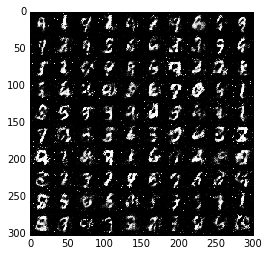

In [14]:
for epoch in range(num_epochs+1):
    for d in dl:
        i, l = d
        i = Variable(i.view(i.size(0), -1))
        real_label = Variable(torch.ones(batch_size))
        fake_label = Variable(torch.zeros(batch_size))
        
        
        #training of discriminator
        o = dis(i)
        dis_loss_val_r = loss_calculator(o, real_label)
        #real_o_d = o
        
        fake_input = Variable(torch.randn(batch_size, 96))
        fake_image = gen(fake_input)
        o = dis(fake_image)
        dis_loss_val_f = loss_calculator(o, fake_label)
        #fake_o_d = o
        
        total_dis_loss = dis_loss_val_r + dis_loss_val_f
        dis.zero_grad()
        total_dis_loss.backward()
        adam_optimize_dis.step()
        
        ############### training of generator
        fake_input = Variable(torch.randn(batch_size, 96))
        gen_output = gen(fake_input)
        o = dis(gen_output)
        
        loss_val_g = loss_calculator(o, real_label) ##as we have to assume that the images genrated by the generator are real and have successfully fooled the discriminator
        
        dis.zero_grad()
        gen.zero_grad()
        loss_val_g.backward()
        adam_optimize_gen.step()
        
    print("Loss after Epoch #{} =  {.4f}", epoch, total_dis_loss.data[0], loss_val_g.data[0])
    if epoch%10==0:
        out = gen_output.data
        out = out.view(out.size(0), 1, 28, 28)
        show(make_grid(out, nrow=10,normalize=True))

        
torch.save(gen.state_dict(), './g.pth')
torch.save(dis.state_dict(), './d.pth')